In [1]:
import os
import numpy as np
import util as util
import cv2
import random

# Steps for data generation

# load the image from the path
# function to read corresponding pose from the file (pose are stored in quaterions)
# create a class or struct for the samples

# s_train =  real + fine
# s_db = coarse folder
# s_test = real

# batch generator function -> triplet generation
# anchor = randomly chosen from the training set
# Puller = most similar to anchor from the db
# pusher = same object different pose and different object pusher

def visualizer(anchor,puller,s_pusher):
    cv2.imshow("anchor ", anchor)
    cv2.imshow("puller", puller)
    cv2.imshow("same class pusher", s_pusher)
    cv2.waitKey(1)

def get_puller(anchor,anc_class,s_db):
    thresh = 2
    thetha_list = []
    puller = -1

    #select only sample from the class
    indx = [i for i in range(s_db['pose'].shape[0]) if s_db['label'][i] ==  anc_class]

    for idx in indx:
        test_pusher = s_db['pose'][idx, :]
        anchor = list(map(float, anchor))
        test_pusher = list(map(float, test_pusher))

        x = np.absolute(np.dot(test_pusher, anchor))
        theth_var = 2 * np.arccos(x)
        thetha_list.append(theth_var)
        

    puller = np.argmin(thetha_list)

    #same class pusher  - code enforces
    a = thetha_list
    s_pusher_value = np.partition(a, thresh)[thresh]
    s_pusher = list(thetha_list).index(s_pusher_value)
    
    #need to change it
    return puller + indx[0], s_pusher + indx[0]


def gen_triplet_list(s_train,s_db):
    print('building triplet list')
    triplet_list = []

    for i in range(s_train['pose'].shape[0]):
        test_anchor = s_train['pose'][i, :]
        test_anchor_class = s_train['label'][i]
        puller, s_pusher = get_puller(test_anchor, test_anchor_class, s_db)
        triplet_list.append([i,puller,s_pusher])
    print('number of triplets = ', len(triplet_list))
    return triplet_list


def  get_batch(s_train,s_db,triplet_list,batch_size):
    batch = []
    idx = random.sample(range(0, len(triplet_list)),batch_size)
    for i in idx:
        t = triplet_list[i]
        batch.append(s_train['img'][t[0],:,:,:])
        batch.append(s_db['img'][t[1],:,:,:])
        batch.append(s_db['img'][t[2],:,:,:])

    return np.asarray(batch)

if '__main__' == __name__:

    base_path = os.getcwd()
    print('path = ', base_path)

    fine_set = util.loadDataset(os.path.join(base_path, "dataset/fine"), 'poses.txt')
    s_db = util.loadDataset(os.path.join(base_path, "dataset/coarse"), 'poses.txt')

    S_db_img=s_db['img']
    S_db_class=s_db['label']
    S_db_quat=s_db['pose']
    
    
    
    real_set = util.loadDataset(os.path.join(base_path, "dataset/real"), 'poses.txt')
    train_idx, test_idx = util.read_indicies(os.path.join(base_path, "dataset/real"), 'training_split.txt')
    s_train = util.build_train_set(real_set,fine_set,train_idx)
    S_train_img=s_train['img']
    S_train_class=s_train['label']
    S_train_quat=s_train['pose']
    

    s_test = util.build_test_set(real_set,test_idx) 
    S_test_img=s_test['img']
    S_test_class=s_test['label']
    S_test_quat=s_test['pose']
    
    
    triplet_list = gen_triplet_list(s_train,s_db)

    print("Db , train, test shapes \n")
    print(S_db_img.shape)
    print(S_train_img.shape)
    print(S_test_img.shape)
    
    print("Db , train, test class annotations \n")
    print(S_train_class)



path =  /Users/nitin/Documents/TUM/TUM/Sem_3/Tracking and Detection/Exercise/Python/Object_Updated
['cat', 'ape', 'duck', 'benchvise', 'cam']
(5055, 64, 64, 3) (5055, 4) (5055,)
['cat', 'ape', 'duck', 'benchvise', 'cam']
(1335, 64, 64, 3) (1335, 4) (1335,)
['cat', 'ape', 'duck', 'benchvise', 'cam']
(5890, 64, 64, 3) (5890, 4) (5890,)
building train set
(7410, 64, 64, 3) (7410, 4) (7410,)
building test set
(3535, 64, 64, 3) (3535, 4) (3535,)
building triplet list


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in arccos


number of triplets =  7410
Db , train, test shapes 

(1335, 64, 64, 3)
(7410, 64, 64, 3)
(3535, 64, 64, 3)
Db , train, test class annotations 

[0 0 0 ... 4 4 4]


In [2]:
S_db_quat[1]

array([-0.19322862, -0.6801931 ,  0.6801931 , -0.19322862], dtype=float32)

In [3]:
import tensorflow as tf
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from util import *

%load_ext autoreload
%autoreload 2

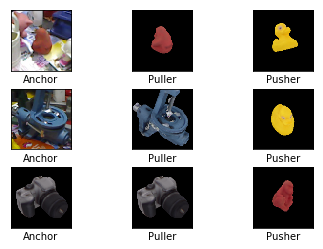

In [4]:
# Displaying a batch of anchor, puller, and pusher
batch_size = 3
batch_img, batch_class, batch_quat = batch_generator(S_train_img, S_train_class, S_train_quat,
                                                     S_db_img, S_db_class, S_db_quat, batch_size)
plot_images(batch_img)

In [5]:
##Normalising the values between (0,1)

S_db_img = np.array(S_db_img, dtype="float32", copy = True)
S_train_img = np.array(S_train_img, dtype="float32", copy = True)
S_test_img = np.array(S_test_img, dtype="float32", copy = True)

for i in range(0, len(S_db_img)):
    S_db_img[i] = normalize_img(S_db_img[i])

for i in range(0, len(S_train_img)):
    S_train_img[i] = normalize_img(S_train_img[i])

for i in range(0, len(S_test_img)):
    S_test_img[i] = normalize_img(S_test_img[i])

    


In [6]:
x = tf.placeholder(tf.float32, shape=[None, 64, 64, 3], name='x')

#LAYERS
layer_conv1 = new_conv_layer(input=x, num_input_channels=3,
                   filter_size=8, num_filters=16, pooling=True, name="Conv1")

layer_conv2 = new_conv_layer(input=layer_conv1, num_input_channels=16,
                   filter_size=5, num_filters=7, pooling=True, name="Conv2")

layer_flat, num_features = flatten_layer(layer_conv2, name="Flatten")
layer_fc1 = new_fc_layer(input=layer_flat, num_inputs=num_features, num_outputs=256, relu=True, name="FC1")
layer_fc2 = new_fc_layer(input=layer_fc1, num_inputs=256, num_outputs=16, relu=False, name="FC2")

#LOSS
loss = total_loss(layer_fc2)

#TYPE OF OPTIMIZER
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(loss)

#SIZES
print(x)
print(layer_conv1)
print(layer_conv2)
print(layer_fc1)
print(layer_fc2)

Tensor("x:0", shape=(?, 64, 64, 3), dtype=float32)
Tensor("MaxPool:0", shape=(?, 28, 28, 16), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 12, 12, 7), dtype=float32)
Tensor("Relu_2:0", shape=(?, 256), dtype=float32)
Tensor("add_3:0", shape=(?, 16), dtype=float32)


In [7]:
##Inserting the parameters into the model

batch_size = 32
epochs = 250
iterations_per_epoch = max(len(S_train_img) // batch_size, 1)
num_iterations = epochs * iterations_per_epoch


In [8]:
batch_size = 32
epochs = 250
iterations_per_epoch = max(len(S_train_img) // batch_size, 1)
num_iterations = epochs * iterations_per_epoch

init = tf.global_variables_initializer()
saver = tf.train.Saver(max_to_keep=None)

logs_path = './logs'
tf.summary.scalar("loss", loss)
merged_summary = tf.summary.merge_all()

with tf.Session() as sess:

    sess.run(init)
    summary_writer = tf.summary.FileWriter(logs_path, sess.graph)
    hist_angles = []
    
    for i in range(0, num_iterations):
        batch_img, batch_class, batch_quat = batch_generator(S_train_img, S_train_class, S_train_quat,
                                                     S_test_img, S_test_class, S_test_quat, batch_size)
        
        _, loss_val, summary = sess.run([optimizer, loss, merged_summary], feed_dict={x: batch_img})

        if i % 10 == 0:
            summary_writer.add_summary(summary, i)
            
        if i % 1000 == 0:
            print("Loss value at iteration " + str(i) + "/" + str(num_iterations-1) + " : " + str(loss_val))
            save_path = saver.save(sess, "./checkpoint/model" + str(i) + ".ckpt")

            db_features, test_features = output_features(S_db_img, S_test_img, layer_fc2, loss, x, i)
            hist, indeces, _ = matching_feature_map(db_features, test_features, S_db_class, S_test_class, S_db_quat, S_test_quat)
            hist_angles.append(hist)
            save_histogram(hist, i)
            print(hist), print()
            
    save_path = saver.save(sess, "./checkpoint/model.ckpt")
    
save_plot_angles(hist_angles)
summary_writer.close()

Loss value at iteration 0/57749 : 8.130266
INFO:tensorflow:./checkpoint/model0.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Restoring parameters from ./checkpoint/model0.ckpt
[ 0.14144272  1.10325318  4.3281471  28.71287129]

Loss value at iteration 1000/57749 : 1.1443081
INFO:tensorflow:./checkpoint/model1000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Restoring parameters from ./checkpoint/model1000.ckpt
[ 3.73408769 17.93493635 47.35502122 93.91796322]

Loss value at iteration 2000/57749 : 0.39949083
INFO:tensorflow:./checkpoint/model2000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Restoring parameters from ./checkpoint/model2000.ckpt
[ 6.13861386 27.86421499 60.70721358 96.03960396]

Loss value at iteration 3000/57749 : 0.27424404
INFO:tensorflow:./checkpoint/model3000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Restoring parameters from ./check

INFO:tensorflow:Restoring parameters from ./checkpoint/model30000.ckpt
[19.00990099 60.56577086 93.63507779 99.88684583]

Loss value at iteration 31000/57749 : 0.054163404
INFO:tensorflow:./checkpoint/model31000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Restoring parameters from ./checkpoint/model31000.ckpt
[17.62376238 60.45261669 93.49363508 99.94342291]

Loss value at iteration 32000/57749 : 0.28577846
INFO:tensorflow:./checkpoint/model32000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Restoring parameters from ./checkpoint/model32000.ckpt
[19.40594059 60.59405941 93.40876945 99.94342291]

Loss value at iteration 33000/57749 : 0.053292725
INFO:tensorflow:./checkpoint/model33000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Restoring parameters from ./checkpoint/model33000.ckpt
[19.43422914 60.50919378 93.43705799 99.97171146]

Loss value at iteration 34000/57749 : 0.058332145
INFO

In [32]:
#index_saved_model = 55000
#db_features, test_features = output_features(S_db_img, S_test_img, layer_fc2, loss, x, index_saved_model)
#hist, indeces, conf_matrix = matching_feature_map(db_features, test_features, S_db_class, S_test_class, S_db_quat, S_test_quat)
#print(hist)

In [33]:
from tensorflow.contrib.tensorboard.plugins import projector

## PCA for feature map (16D → 3D)

In [34]:
LOG_DIR = './logs'
names = ["ape", "benchvise", "cam", "cat", "duck"]

#Classification of test data in PCA 3D
metadata_file = open(os.path.join(LOG_DIR, 'metadata.tsv'), 'w')
metadata_file.write('Name\tClass\n')
for i in range(len(S_test_class)):
    metadata_file.write('%06d\t%s\n' % (i, names[S_test_class[i]]))
metadata_file.close() 


with tf.Session() as sess:
    
    embedding_var = tf.Variable(test_features,  name='feature_map')
    sess.run(embedding_var.initializer)
    
    summary_writer = tf.summary.FileWriter(LOG_DIR)
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_var.name

    #metadata
    embedding.metadata_path = os.path.join('metadata.tsv')

    projector.visualize_embeddings(summary_writer, config)
    saver = tf.train.Saver([embedding_var])
    saver.save(sess, os.path.join(LOG_DIR, 'model2.ckpt'), 1)

## Confusion Matrix

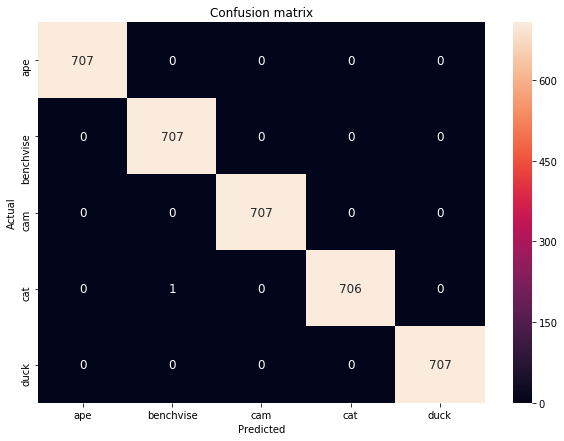

In [35]:
names = ['ape', 'benchvise', 'cam', 'cat', 'duck']
conf_matrix = np.array(conf_matrix, copy = True, dtype = "int16")

df = pd.DataFrame(conf_matrix, index = names, columns = names)

plt.figure(figsize = (10,7))
ax = plt.axes()
sn.heatmap(df, annot=True, annot_kws={"size": 12}, fmt="d")
ax.set_title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

plt.clf()
plt.cla()
plt.close()